<a href="https://colab.research.google.com/github/devakar771/Music-genre-classification/blob/main/Music_genre_classification_ENSEMBLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries & Data

In [1]:
!pip install eli5

     |████████████████████████████████| 106 kB 5.1 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Datasets/gtzan-dataset-music-genre-classification.zip

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import uniform, randint
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import sklearn.ensemble as ske
import eli5
from eli5.sklearn import PermutationImportance
from pprint import pprint
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

## Loading Dataset

In [ ]:
df = pd.read_csv('/content/data.csv')
df.head()

filename  chroma_stft_mean  ...  mfcc20_var  label
0  blues.00058.0.wav          0.351261  ...   68.367340  blues
1  blues.00058.1.wav          0.313837  ...   82.116333  blues
2  blues.00058.2.wav          0.344683  ...   59.151276  blues
3  blues.00058.3.wav          0.348661  ...   76.562775  blues
4  blues.00058.4.wav          0.369689  ...   78.359436  blues

[5 rows x 54 columns]

## About dataset

In [ ]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (27972, 54)
Count of Positive and Negative samples


index  label
0        pop   2800
1      disco   2800
2       rock   2800
3  classical   2800
4      metal   2800
5     reggae   2800
6    country   2800
7     hiphop   2800
8      blues   2800
9       jazz   2772

# Data Visualization

In [ ]:
audio_fp = '/content/Data/genres_original/classical/classical.00000.wav'
audio_data, sr = librosa.load(audio_fp)
audio_data, _ = librosa.effects.trim(audio_data)

In [ ]:
# play sample file
IPython.display.Audio(audio_data, rate=sr)

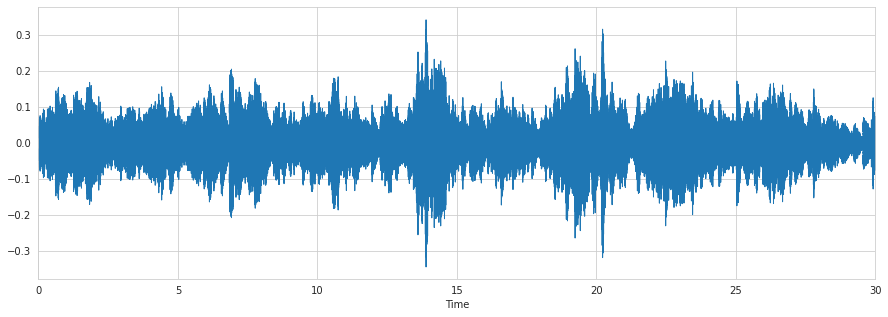

In [ ]:
# plot sample file
plt.figure(figsize=(15,5))
lplt.waveplot(audio_data)
plt.show()

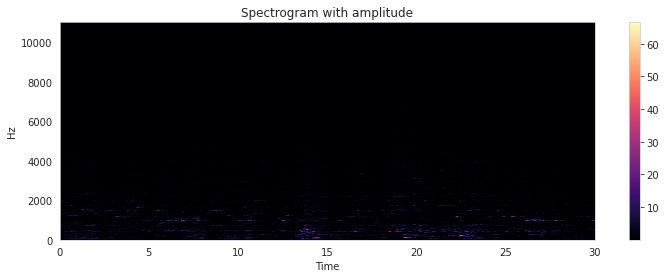

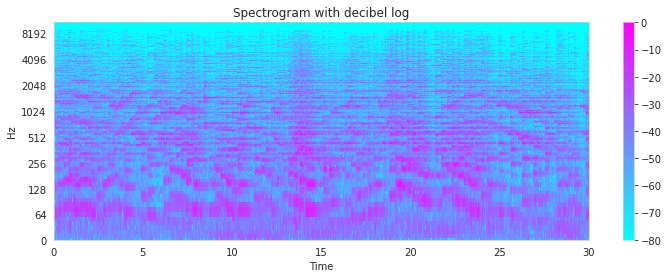

In [ ]:
# Default FFT window size
n_fft = 2048 # window size
hop_length = 512 # window hop length for STFT

stft = librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length)
stft_db = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=(12,4))
lplt.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title("Spectrogram with amplitude")
plt.show()

plt.figure(figsize=(12,4))
lplt.specshow(stft_db, sr=sr, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Spectrogram with decibel log")
plt.show()

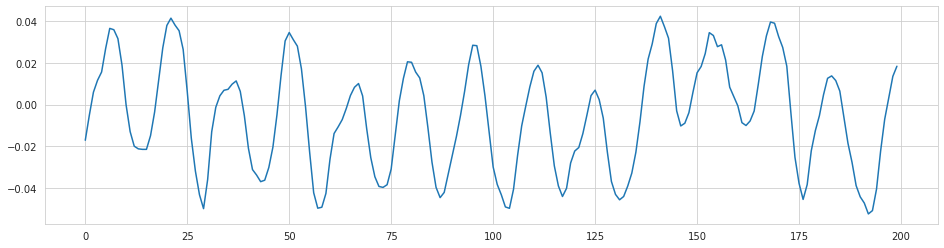

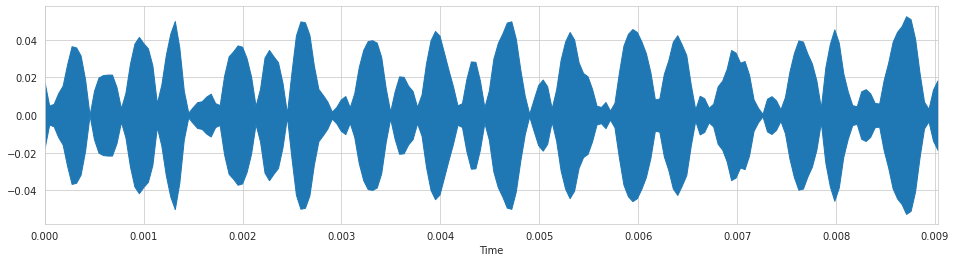

In [ ]:
# plot zoomed audio wave 
start = 1000
end = 1200
plt.figure(figsize=(16,4))
plt.plot(audio_data[start:end])
plt.figure(figsize=(16,4))
lplt.waveplot(audio_data[start:end])
plt.show()

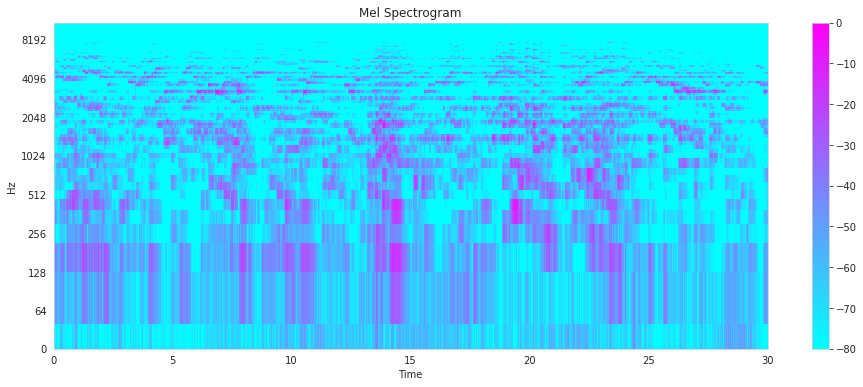

In [ ]:
mel_spec = librosa.feature.melspectrogram(audio_data, sr=sr)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
plt.figure(figsize=(16,6))
lplt.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()

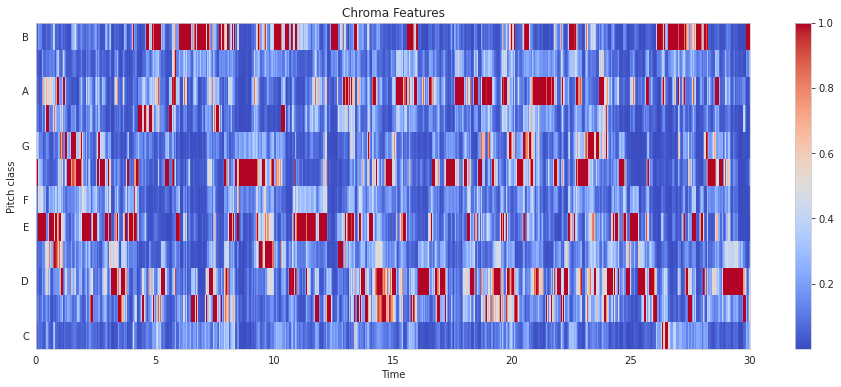

In [ ]:
chroma = librosa.feature.chroma_stft(audio_data, sr=sr)
plt.figure(figsize=(16,6))
lplt.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

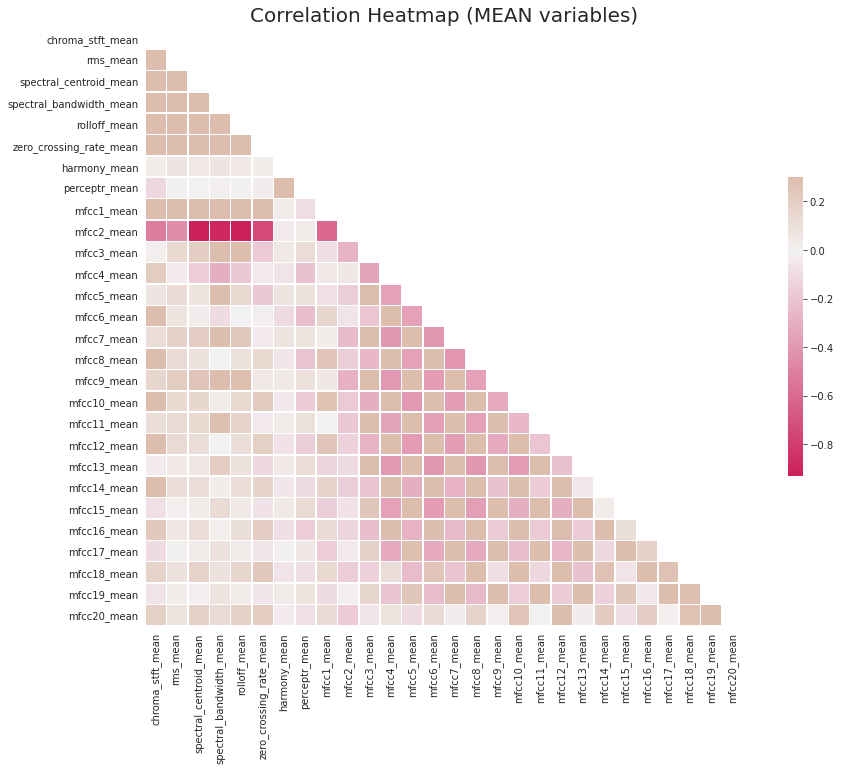

In [ ]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr_Heatmap.png")

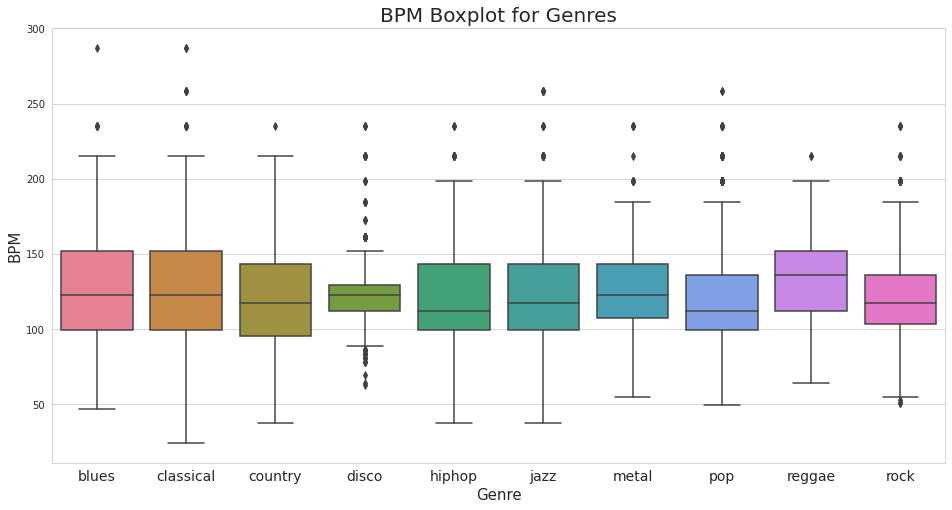

In [ ]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

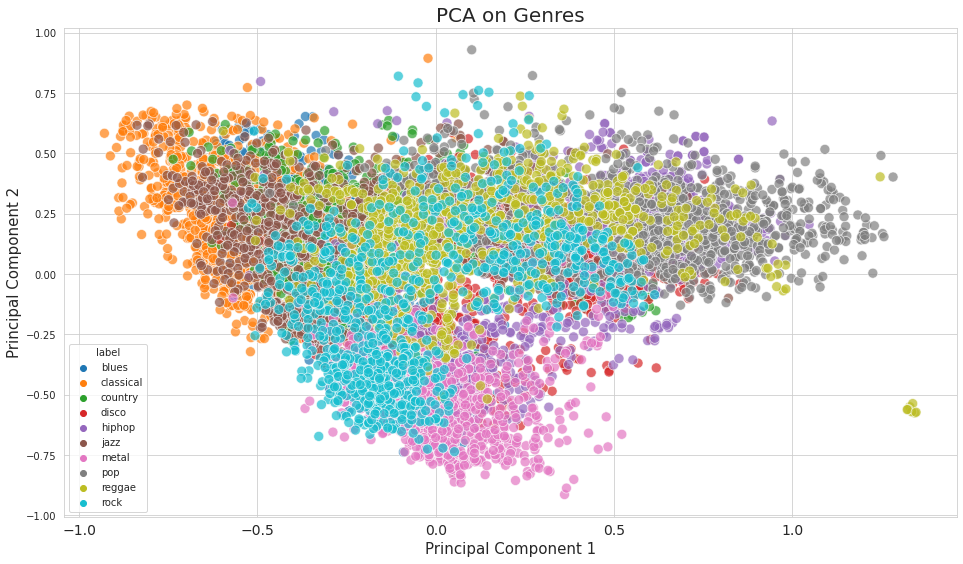

In [ ]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 pca components
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

# concatenate with target label
finalDf = pd.concat([principalDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "pc1", y = "pc2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('PCA on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Principal Component 1", fontsize = 15)
plt.ylabel("Principal Component 2", fontsize = 15)
plt.savefig("PCA_Scattert.png")

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9990 samples in 0.065s...
[t-SNE] Computed neighbors for 9990 samples in 12.330s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9990
[t-SNE] Computed conditional probabilities for sample 2000 / 9990
[t-SNE] Computed conditional probabilities for sample 3000 / 9990
[t-SNE] Computed conditional probabilities for sample 4000 / 9990
[t-SNE] Computed conditional probabilities for sample 5000 / 9990
[t-SNE] Computed conditional probabilities for sample 6000 / 9990
[t-SNE] Computed conditional probabilities for sample 7000 / 9990
[t-SNE] Computed conditional probabilities for sample 8000 / 9990
[t-SNE] Computed conditional probabilities for sample 9000 / 9990
[t-SNE] Computed conditional probabilities for sample 9990 / 9990
[t-SNE] Mean sigma: 0.201116
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.564270
[t-SNE] KL divergence after 300 iterations: 2.784433


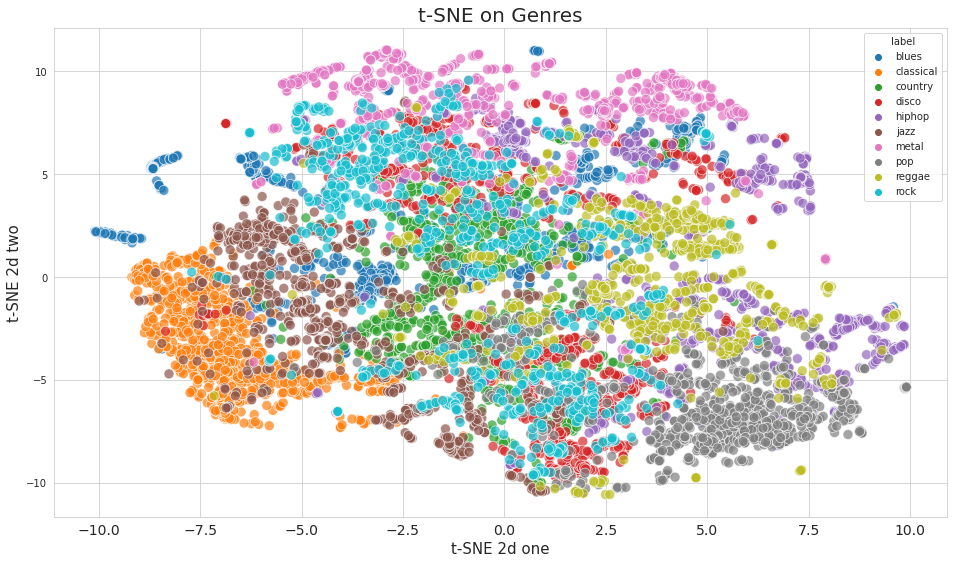

In [9]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

# normalize
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

# Top 2 t-SNE components
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)
tsneDf = pd.DataFrame(data = tsne_results, columns = ['tsne1', 'tsne2'])

# concatenate with target label
finalDf = pd.concat([tsneDf, y], axis = 1)

plt.figure(figsize = (16, 9))
sns.scatterplot(x = "tsne1", y = "tsne2", data = finalDf, hue = "label", alpha = 0.7, s = 100);

plt.title('t-SNE on Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("t-SNE 2d one", fontsize = 15)
plt.ylabel("t-SNE 2d two", fontsize = 15)
plt.savefig("t-SNE_Scattert.png")

In [ ]:
X.shape,principalComponents.shape

((9990, 58), (9990, 2))

In [ ]:
# find all columns with any NA values
print("Columns with NA values are",list(df.columns[df.isnull().any()]))

Columns with NA values are []


`No null values in the dataset`



`There are no categorical variable as such. Hence, Dummy variable creation is not needed.`

## Encode Genre Label

In [ ]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [ ]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]

# Split Train Dev & Test Sets

In [ ]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [ ]:
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [ ]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [ ]:
print(y_train.value_counts()[0]/y_train.shape[0]*100)
print(y_dev.value_counts()[0]/y_dev.shape[0]*100)
print(y_test.value_counts()[0]/y_test.shape[0]*100)

10.01001001001001
10.010111223458038
10.009813542688912


## Scale the Features

In [ ]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

# Feature Selection

## Sample Logistic Regression Model

Building model with all the available features.

In [ ]:
def predictProba(clf, X, dev=False):
    y_true = y_train
    if dev:
        X = X_dev[X.columns]
        y_true = y_dev
    y_pred_proba_X = clf.predict_proba(X)
    y_pred_X = clf.predict(X)
    fig, ax = plt.subplots(figsize=(6, 6))
    skm.plot_confusion_matrix(clf, X, y_true, display_labels=y.unique(), cmap=plt.cm.Blues, xticks_rotation=90, ax=ax)
    plt.show()
    print(skm.classification_report(y_true, y_pred_X, digits=3))
    print("=====================================================")

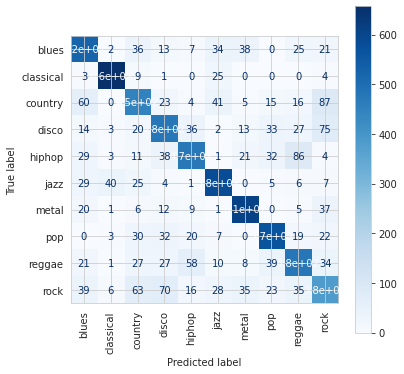

              precision    recall  f1-score   support

       blues      0.709     0.749     0.728       700
   classical      0.918     0.940     0.929       699
     country      0.663     0.640     0.652       698
       disco      0.684     0.681     0.682       699
      hiphop      0.758     0.678     0.716       699
        jazz      0.796     0.833     0.814       700
       metal      0.835     0.870     0.852       700
         pop      0.794     0.810     0.802       700
      reggae      0.684     0.679     0.681       700
        rock      0.568     0.549     0.558       698

    accuracy                          0.743      6993
   macro avg      0.741     0.743     0.742      6993
weighted avg      0.741     0.743     0.742      6993



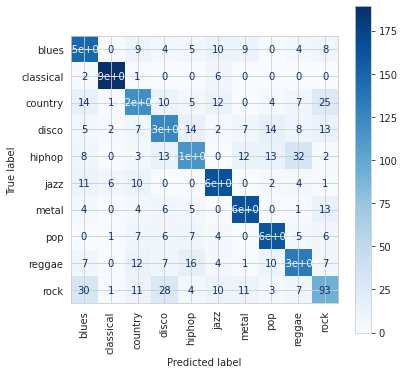

              precision    recall  f1-score   support

       blues      0.648     0.753     0.696       198
   classical      0.945     0.955     0.950       198
     country      0.650     0.604     0.626       197
       disco      0.630     0.636     0.633       198
      hiphop      0.671     0.579     0.621       197
        jazz      0.774     0.828     0.800       198
       metal      0.805     0.833     0.819       198
         pop      0.779     0.818     0.798       198
      reggae      0.663     0.677     0.670       198
        rock      0.554     0.470     0.508       198

    accuracy                          0.715      1978
   macro avg      0.712     0.715     0.712      1978
weighted avg      0.712     0.715     0.712      1978



In [ ]:
lr = LogisticRegression(random_state=seed)
lr.fit(X_train,y_train)
predictProba(lr, X_train)
predictProba(lr, X_train, dev=True)

## Permutation Importance Feature Selection

In [ ]:
perm = PermutationImportance(lr, random_state=seed).fit(X_train, y_train, n_iter=10)
print("Feature Importances using Permutation Importance")
eli5.show_weights(perm, feature_names = X_dev.columns.tolist())

Feature Importances using Permutation Importance


#### Plot Permutation Importances

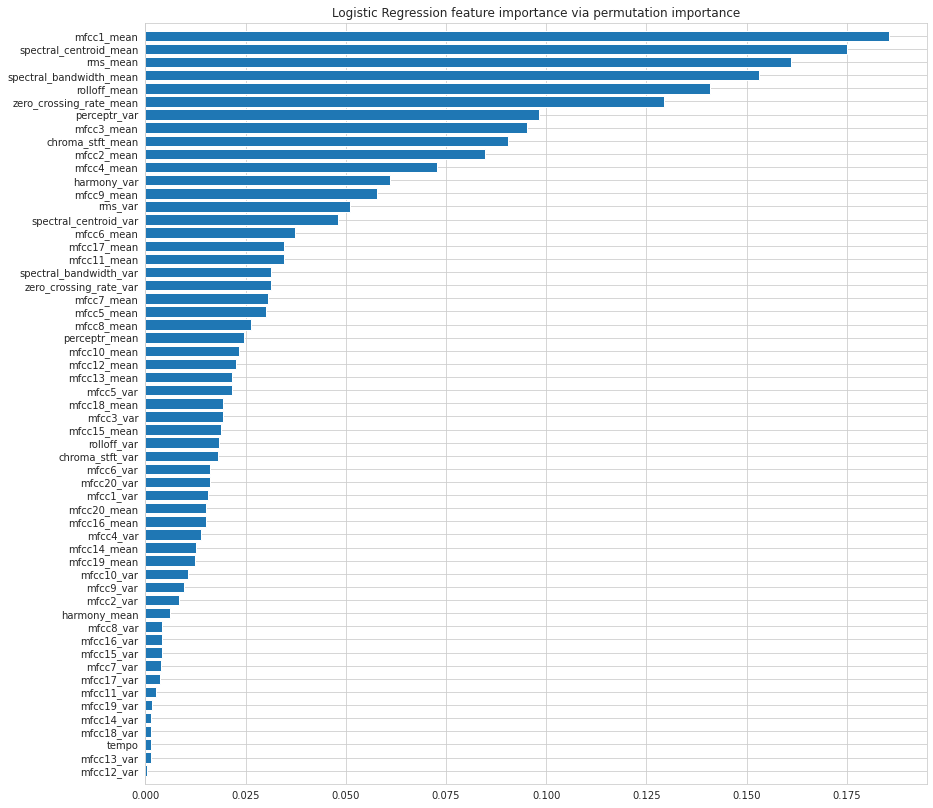

In [ ]:
# plot the permutation importances
perm_indices = np.argsort(perm.feature_importances_)[::-1]
perm_features = [X_dev.columns.tolist()[xx] for xx in perm_indices]
plt.figure(figsize=(14, 14))
plt.title("Logistic Regression feature importance via permutation importance")
plt.barh(range(X_dev.shape[1]), perm.feature_importances_[perm_indices])
plt.yticks(range(X_dev.shape[1]), perm_features)
plt.ylim([X_dev.shape[1], -1])
plt.show()

#### Model Score using Permutation Importances

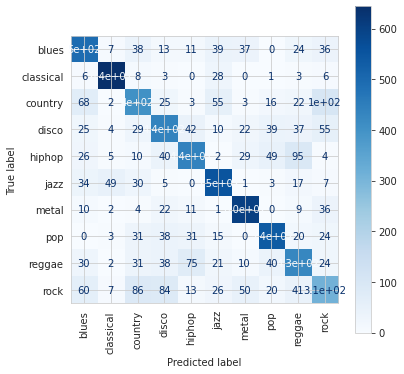

              precision    recall  f1-score   support

       blues      0.656     0.707     0.681       700
   classical      0.888     0.921     0.904       699
     country      0.601     0.577     0.589       698
       disco      0.619     0.624     0.622       699
      hiphop      0.702     0.628     0.663       699
        jazz      0.738     0.791     0.764       700
       metal      0.799     0.864     0.830       700
         pop      0.762     0.769     0.765       700
      reggae      0.615     0.613     0.614       700
        rock      0.515     0.446     0.478       698

    accuracy                          0.694      6993
   macro avg      0.690     0.694     0.691      6993
weighted avg      0.690     0.694     0.691      6993



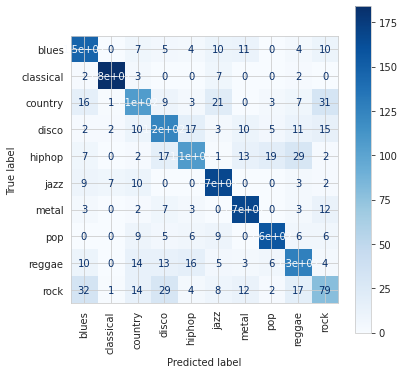

              precision    recall  f1-score   support

       blues      0.645     0.742     0.690       198
   classical      0.944     0.929     0.936       198
     country      0.599     0.538     0.567       197
       disco      0.591     0.621     0.606       198
      hiphop      0.669     0.543     0.599       197
        jazz      0.723     0.843     0.779       198
       metal      0.774     0.848     0.810       198
         pop      0.818     0.793     0.805       198
      reggae      0.608     0.641     0.624       198
        rock      0.491     0.399     0.440       198

    accuracy                          0.690      1978
   macro avg      0.686     0.690     0.686      1978
weighted avg      0.686     0.690     0.686      1978



In [ ]:
# build model using perm selected top 30 features
lr = LogisticRegression()
X_train_perm = X_train[perm_features[:30]]
X_train_rfe = X_train_perm
lr.fit(X_train_perm,y_train)
predictProba(lr, X_train_perm)
predictProba(lr, X_train_perm, dev=True)

## Correlation Heatmap

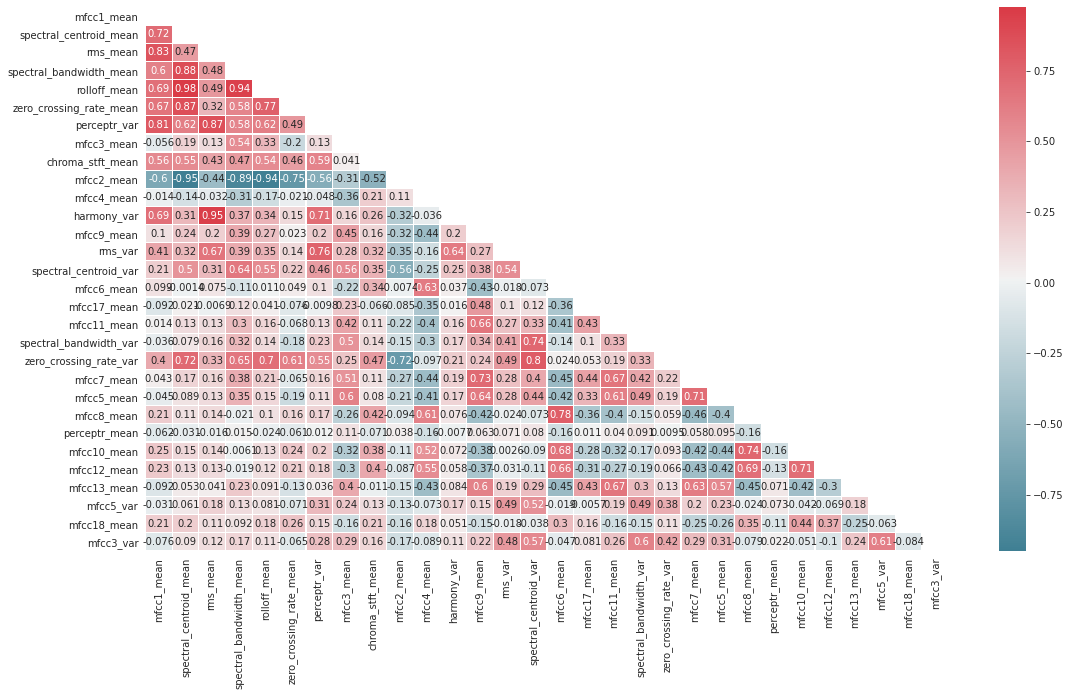

In [ ]:
# plot correlation among top 30 selected featuers
corr = X_train_perm.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize = (18, 10))
sns.heatmap(corr,mask=mask, annot = True, linewidths=.2, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

# Model Building

## Logistic Regression

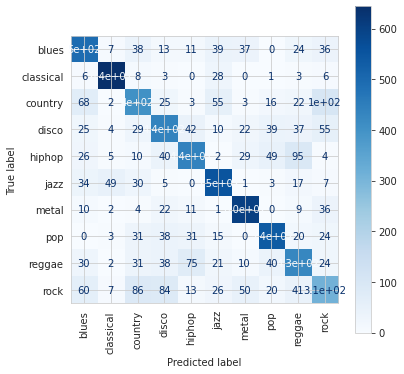

              precision    recall  f1-score   support

       blues      0.656     0.707     0.681       700
   classical      0.888     0.921     0.904       699
     country      0.601     0.577     0.589       698
       disco      0.619     0.624     0.622       699
      hiphop      0.702     0.628     0.663       699
        jazz      0.738     0.791     0.764       700
       metal      0.799     0.864     0.830       700
         pop      0.762     0.769     0.765       700
      reggae      0.615     0.613     0.614       700
        rock      0.515     0.446     0.478       698

    accuracy                          0.694      6993
   macro avg      0.690     0.694     0.691      6993
weighted avg      0.690     0.694     0.691      6993



In [ ]:
lr = LogisticRegression()
lr.fit(X_train_rfe,y_train)
predictProba(lr, X_train_rfe)

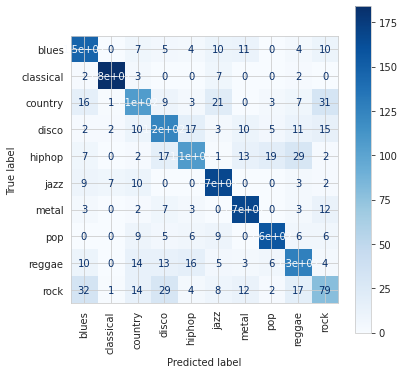

              precision    recall  f1-score   support

       blues      0.645     0.742     0.690       198
   classical      0.944     0.929     0.936       198
     country      0.599     0.538     0.567       197
       disco      0.591     0.621     0.606       198
      hiphop      0.669     0.543     0.599       197
        jazz      0.723     0.843     0.779       198
       metal      0.774     0.848     0.810       198
         pop      0.818     0.793     0.805       198
      reggae      0.608     0.641     0.624       198
        rock      0.491     0.399     0.440       198

    accuracy                          0.690      1978
   macro avg      0.686     0.690     0.686      1978
weighted avg      0.686     0.690     0.686      1978



In [ ]:
predictProba(lr, X_train_rfe, True)

# BAGGING

## Random Forest

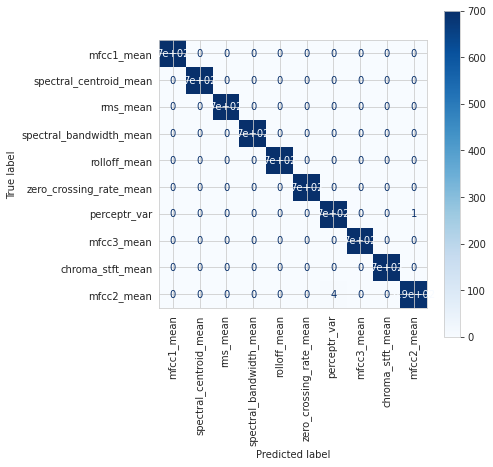

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      1.000     1.000     1.000       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     1.000     1.000       700
           6      0.994     0.999     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.999     0.994     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [ ]:
rfc = ske.RandomForestClassifier(random_state=seed, n_jobs=-1)
rfc.fit(X_train_rfe, y_train)
predictProba(rfc, X_train_rfe)

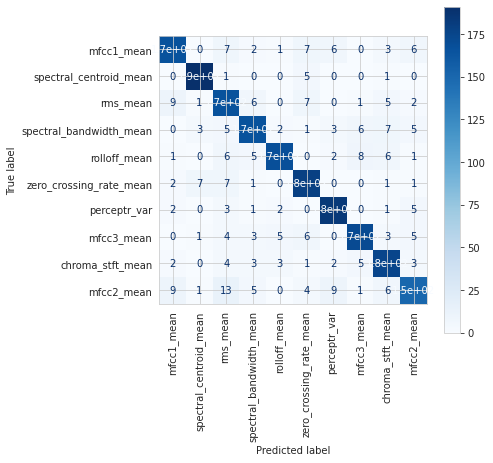

              precision    recall  f1-score   support

           0      0.869     0.838     0.853       198
           1      0.936     0.965     0.950       198
           2      0.769     0.843     0.804       197
           3      0.865     0.838     0.851       198
           4      0.928     0.853     0.889       197
           5      0.852     0.904     0.877       198
           6      0.893     0.929     0.911       198
           7      0.891     0.864     0.877       198
           8      0.841     0.884     0.862       198
           9      0.843     0.758     0.798       198

    accuracy                          0.868      1978
   macro avg      0.869     0.868     0.867      1978
weighted avg      0.869     0.868     0.867      1978



In [ ]:
predictProba(rfc, X_train_rfe, True)

## Logistic regression + Decision tree + KNN + RF + ExtraTress

In [ ]:
lr_clf = LogisticRegression() 
dt_clf = DecisionTreeClassifier() 
rf_clf = RandomForestClassifier() 
et_clf = ExtraTreesClassifier() 
knn_clf = KNeighborsClassifier() 

classifiers =[lr_clf, dt_clf, rf_clf, et_clf, knn_clf]
for clf in classifiers:
    clf_scores = cross_val_score(clf, X_train_rfe, y_train, cv = 10)
    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=10, random_state=0)
    bagging_clf_scores = cross_val_score(bagging_clf, X_train_rfe, y_train, cv = 10)
    print(clf.__class__.__name__, ":::: Mean:", clf_scores.mean(), ", Std Dev:", clf_scores.std())
    print("Bagging", clf.__class__.__name__, ":::: Mean:", bagging_clf_scores.mean(), "Std Dev:", bagging_clf_scores.std(), "\n")

ensembler = VotingClassifier(estimators=[('LogisticRegression', lr_clf), ('DecisionTreeClassifier', dt_clf),
                                        ('RandomForestClassifier', rf_clf), ('ExtraTreesClassifier', et_clf),
                                        ('KNeighborsClassifier', knn_clf)], voting = 'hard')

ensembler_scores = cross_val_score(ensembler, X_train_rfe, y_train, n_jobs=-1, cv = 10)
print(ensembler.__class__.__name__, ":::: Mean:", ensembler_scores.mean(), "Std Dev:", clf_scores.std())


LogisticRegression :::: Mean: 0.6819621908849376 , Std Dev: 0.016905116443459402
Bagging LogisticRegression :::: Mean: 0.5961620682607807 Std Dev: 0.02315545114601407 

DecisionTreeClassifier :::: Mean: 0.6463605150214593 , Std Dev: 0.014358571412397448
Bagging DecisionTreeClassifier :::: Mean: 0.6988454935622318 Std Dev: 0.01950994740653369 

RandomForestClassifier :::: Mean: 0.8598604128346619 , Std Dev: 0.016971189403375657
Bagging RandomForestClassifier :::: Mean: 0.7792021254853873 Std Dev: 0.016326580060827028 

ExtraTreesClassifier :::: Mean: 0.8868877988963828 , Std Dev: 0.014800479578682434
Bagging ExtraTreesClassifier :::: Mean: 0.8083754342938893 Std Dev: 0.012466263250570339 

KNeighborsClassifier :::: Mean: 0.8795943184140608 , Std Dev: 0.012604755981481534
Bagging KNeighborsClassifier :::: Mean: 0.8060880850194154 Std Dev: 0.015771454478867533 

VotingClassifier :::: Mean: 0.8848824851829142 Std Dev: 0.012604755981481534


# BOOSTING

## AdaBoost

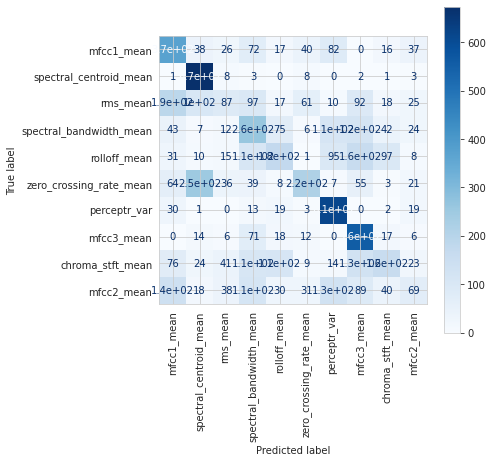

              precision    recall  f1-score   support

           0      0.394     0.531     0.453       700
           1      0.591     0.963     0.732       699
           2      0.323     0.125     0.180       698
           3      0.296     0.375     0.331       699
           4      0.372     0.250     0.299       699
           5      0.558     0.309     0.397       700
           6      0.577     0.876     0.695       700
           7      0.462     0.794     0.584       700
           8      0.407     0.231     0.295       700
           9      0.294     0.099     0.148       698

    accuracy                          0.455      6993
   macro avg      0.427     0.455     0.412      6993
weighted avg      0.428     0.455     0.412      6993



In [ ]:
abc = ske.AdaBoostClassifier(n_estimators=100, random_state=seed)
abc.fit(X_train_rfe, y_train)
predictProba(abc, X_train_rfe)

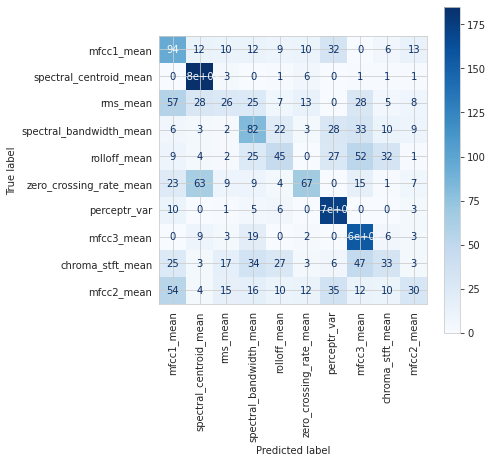

              precision    recall  f1-score   support

           0      0.338     0.475     0.395       198
           1      0.595     0.934     0.727       198
           2      0.295     0.132     0.182       197
           3      0.361     0.414     0.386       198
           4      0.344     0.228     0.274       197
           5      0.578     0.338     0.427       198
           6      0.575     0.874     0.693       198
           7      0.453     0.788     0.576       198
           8      0.317     0.167     0.219       198
           9      0.385     0.152     0.217       198

    accuracy                          0.450      1978
   macro avg      0.424     0.450     0.410      1978
weighted avg      0.424     0.450     0.410      1978



In [ ]:
predictProba(abc, X_train_rfe, True)

## GBM

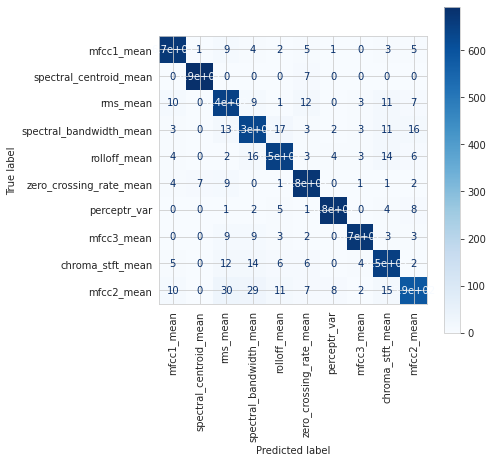

              precision    recall  f1-score   support

           0      0.949     0.957     0.953       700
           1      0.989     0.990     0.989       699
           2      0.884     0.924     0.903       698
           3      0.884     0.903     0.893       699
           4      0.934     0.926     0.930       699
           5      0.936     0.964     0.950       700
           6      0.978     0.970     0.974       700
           7      0.977     0.959     0.968       700
           8      0.913     0.930     0.921       700
           9      0.923     0.840     0.879       698

    accuracy                          0.936      6993
   macro avg      0.937     0.936     0.936      6993
weighted avg      0.937     0.936     0.936      6993



In [ ]:
gbc = ske.GradientBoostingClassifier(n_estimators=100, random_state=seed)
gbc.fit(X_train_rfe, y_train)
predictProba(gbc, X_train_rfe)

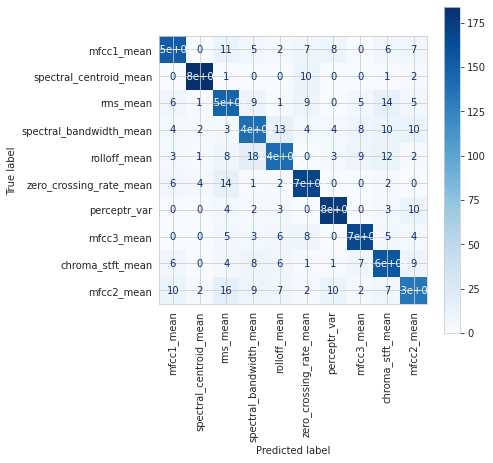

              precision    recall  f1-score   support

           0      0.813     0.768     0.790       198
           1      0.948     0.929     0.939       198
           2      0.690     0.746     0.717       197
           3      0.718     0.707     0.712       198
           4      0.779     0.716     0.746       197
           5      0.805     0.854     0.828       198
           6      0.871     0.889     0.880       198
           7      0.843     0.843     0.843       198
           8      0.722     0.788     0.754       198
           9      0.731     0.672     0.700       198

    accuracy                          0.791      1978
   macro avg      0.792     0.791     0.791      1978
weighted avg      0.792     0.791     0.791      1978



In [ ]:
predictProba(gbc, X_train_rfe, True)

## XGBoost

In [ ]:
import xgboost as xgb
print(xgb.__version__)

0.90


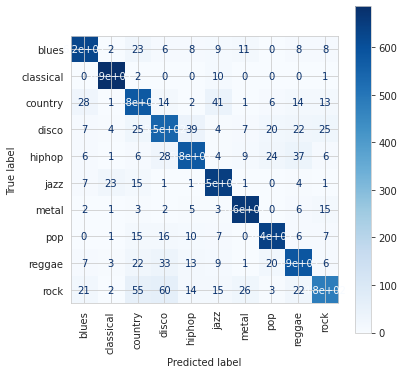

              precision    recall  f1-score   support

       blues      0.889     0.893     0.891       700
   classical      0.948     0.981     0.964       699
     country      0.777     0.828     0.802       698
       disco      0.773     0.781     0.777       699
      hiphop      0.863     0.827     0.844       699
        jazz      0.864     0.924     0.893       700
       metal      0.922     0.947     0.934       700
         pop      0.897     0.911     0.904       700
      reggae      0.831     0.837     0.834       700
        rock      0.854     0.688     0.762       698

    accuracy                          0.862      6993
   macro avg      0.862     0.862     0.861      6993
weighted avg      0.862     0.862     0.861      6993



In [ ]:
xgbc = xgb.XGBClassifier(n_estimators=100, random_state=seed)
xgbc.fit(X_train_rfe, y_train)
predictProba(xgbc, X_train_rfe)

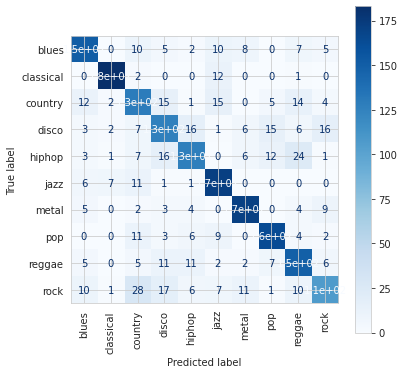

              precision    recall  f1-score   support

       blues      0.774     0.763     0.768       198
   classical      0.934     0.924     0.929       198
     country      0.608     0.655     0.631       197
       disco      0.640     0.636     0.638       198
      hiphop      0.730     0.645     0.685       197
        jazz      0.754     0.869     0.808       198
       metal      0.838     0.864     0.851       198
         pop      0.803     0.823     0.813       198
      reggae      0.680     0.753     0.715       198
        rock      0.713     0.540     0.615       198

    accuracy                          0.747      1978
   macro avg      0.748     0.747     0.745      1978
weighted avg      0.748     0.747     0.745      1978



In [ ]:
predictProba(xgbc, X_train_rfe, True)

In [ ]:
!pip install catboost

     |████████████████████████████████| 67.4 MB 27 kB/s 


## CatBoost

In [ ]:
import catboost as cb
print(cb.__version__)

0.26.1


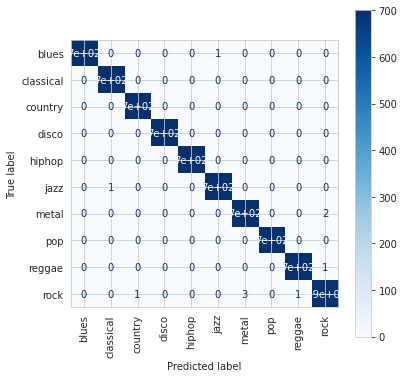

              precision    recall  f1-score   support

       blues      1.000     0.999     0.999       700
   classical      0.999     1.000     0.999       699
     country      0.999     1.000     0.999       698
       disco      1.000     1.000     1.000       699
      hiphop      1.000     1.000     1.000       699
        jazz      0.999     0.999     0.999       700
       metal      0.996     0.997     0.996       700
         pop      1.000     1.000     1.000       700
      reggae      0.999     0.999     0.999       700
        rock      0.996     0.993     0.994       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [ ]:
cbc = cb.CatBoostClassifier(random_state=seed, verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
cbc.fit(X_train_rfe, y_train)
predictProba(cbc, X_train_rfe)

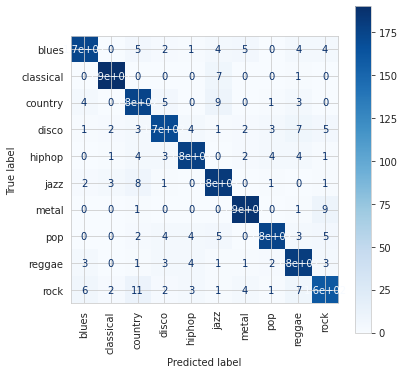

              precision    recall  f1-score   support

       blues      0.915     0.874     0.894       198
   classical      0.960     0.960     0.960       198
     country      0.833     0.888     0.860       197
       disco      0.895     0.859     0.876       198
      hiphop      0.918     0.904     0.910       197
        jazz      0.867     0.919     0.892       198
       metal      0.930     0.944     0.937       198
         pop      0.936     0.884     0.909       198
      reggae      0.857     0.909     0.882       198
        rock      0.852     0.813     0.832       198

    accuracy                          0.895      1978
   macro avg      0.896     0.895     0.895      1978
weighted avg      0.896     0.895     0.895      1978



In [ ]:
predictProba(cbc, X_train_rfe, True)

# STACKING

In [ ]:
def get_stacking():
    level0 = [('lr_classifier', LogisticRegression()), ('dt_classifier', DecisionTreeClassifier()),
              ('knn_classifier', KNeighborsClassifier()), ('svm_classifier', SVC()), ('gnb_classifier', GaussianNB())]
    level1 = LogisticRegression()
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=10)
    return model


lr_classifier = LogisticRegression()
dt_classifier = DecisionTreeClassifier()
knn_classifier = KNeighborsClassifier()
svm_classifier = SVC()
gnb_classifier = GaussianNB()
stacking_classifier = get_stacking()

classifiers = [lr_classifier, dt_classifier, knn_classifier, svm_classifier, gnb_classifier, stacking_classifier]
for clf in classifiers:
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)
    clf_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(clf.__class__.__name__, ":::: Mean:", clf_scores.mean(), "Std Dev:", clf_scores.std())

LogisticRegression :::: Mean: 0.7186238163362627 Std Dev: 0.016579213662067296
DecisionTreeClassifier :::: Mean: 0.6360214592274678 Std Dev: 0.01820622263724834
KNeighborsClassifier :::: Mean: 0.8610045643436202 Std Dev: 0.012574613361254296
SVC :::: Mean: 0.8423652837386744 Std Dev: 0.014093554910792748
GaussianNB :::: Mean: 0.5214738742421147 Std Dev: 0.01457149245041853
StackingClassifier :::: Mean: 0.8985656379862389 Std Dev: 0.01110488187743433


# Model Tuning

Tuning selected models which performed good as base models.

## LR Model HP Tuning

## DST Model HP Tuning

## ET Model HP Tuning

## SVM Model HP Tuning

## GNB Model HP Tuning

## KNN Model HP Tuning

## RF Model HP Tuning

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 4)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 60, num = 5)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 15]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

pprint(random_grid)

{'max_depth': [1, 15, 30, 45, 60],
 'min_samples_split': [5, 10, 15],
 'n_estimators': [10, 140, 270, 400]}


In [ ]:
# Use grid search to find best hyperparameters
rfc_n = ske.RandomForestClassifier(random_state=seed, n_jobs=-1)
rf_random = skms.GridSearchCV(estimator = rfc_n, param_grid=random_grid, cv = 5, verbose=2, n_jobs = -1, scoring='f1_weighted')
# Fit the random search model
rf_random.fit(X_train_rfe, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=12,
                                    

In [ ]:
# best random model 
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)


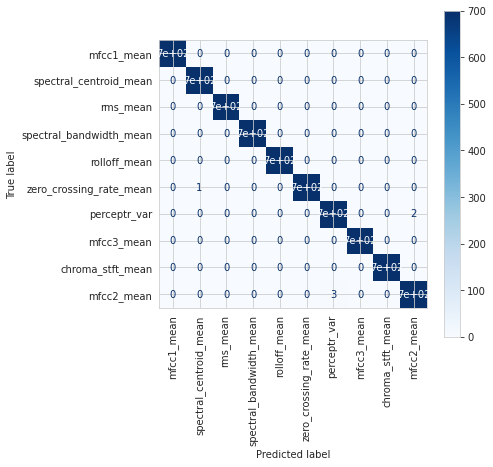

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      0.999     1.000     0.999       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     0.999     0.999       700
           6      0.996     0.997     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.997     0.996     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [ ]:
# Performance metrics
predictProba(rf_random.best_estimator_, X_train_rfe)

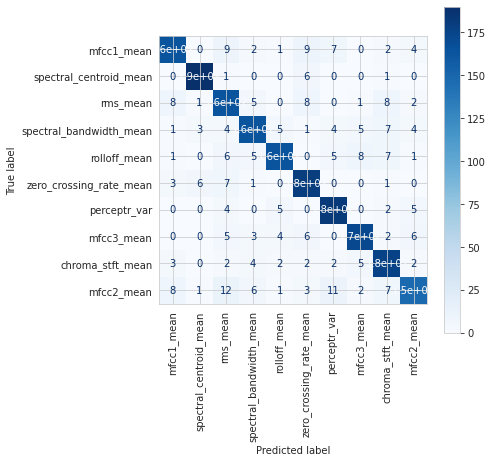

              precision    recall  f1-score   support

           0      0.872     0.828     0.850       198
           1      0.945     0.960     0.952       198
           2      0.766     0.832     0.798       197
           3      0.863     0.828     0.845       198
           4      0.901     0.832     0.865       197
           5      0.837     0.909     0.872       198
           6      0.863     0.919     0.890       198
           7      0.891     0.869     0.880       198
           8      0.826     0.889     0.856       198
           9      0.860     0.742     0.797       198

    accuracy                          0.861      1978
   macro avg      0.863     0.861     0.861      1978
weighted avg      0.863     0.861     0.861      1978



In [ ]:
predictProba(rf_random.best_estimator_, X_train_rfe, True)

## XGB Model HP Tuning

In [ ]:
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=seed)

xgb_params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

In [ ]:
# Use the random grid to search for best hyperparameters
xgb_random = skms.RandomizedSearchCV(estimator = xgb_model, param_distributions=xgb_params, n_iter=20, cv = 3, verbose=2, n_jobs = -1, random_state=seed, scoring='f1_weighted', return_train_score=True)
# Fit the random search model
xgb_random.fit(X_train_rfe, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 10.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=12, reg_alpha=0,
                                           reg_lambda=1, s...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efe9d47df10>,
                                        'n_estimator

In [ ]:
# best xgb_random model 
print(xgb_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9066782998097372,
              gamma=0.0016439843761698048, learning_rate=0.3000310498970947,
              max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
              n_estimators=137, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=12, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.6023637423473936, verbosity=1)


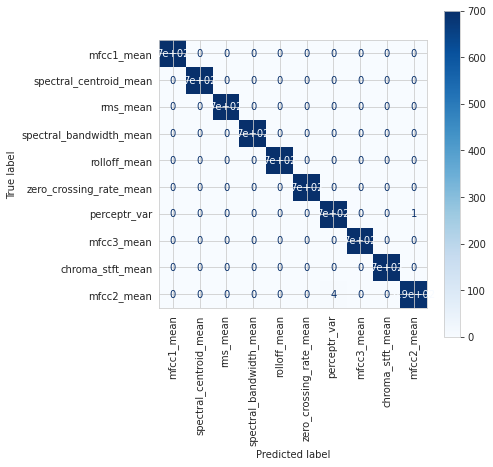

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       700
           1      1.000     1.000     1.000       699
           2      1.000     1.000     1.000       698
           3      1.000     1.000     1.000       699
           4      1.000     1.000     1.000       699
           5      1.000     1.000     1.000       700
           6      0.994     0.999     0.996       700
           7      1.000     1.000     1.000       700
           8      1.000     1.000     1.000       700
           9      0.999     0.994     0.996       698

    accuracy                          0.999      6993
   macro avg      0.999     0.999     0.999      6993
weighted avg      0.999     0.999     0.999      6993



In [ ]:
# Performance metrics
predictProba(xgb_random.best_estimator_, X_train_rfe)

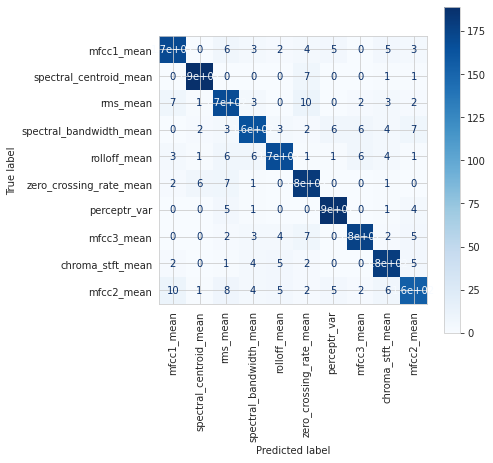

              precision    recall  f1-score   support

           0      0.876     0.859     0.867       198
           1      0.945     0.955     0.950       198
           2      0.816     0.858     0.837       197
           3      0.868     0.833     0.851       198
           4      0.898     0.853     0.875       197
           5      0.838     0.914     0.874       198
           6      0.917     0.944     0.930       198
           7      0.916     0.884     0.900       198
           8      0.869     0.904     0.886       198
           9      0.847     0.783     0.814       198

    accuracy                          0.879      1978
   macro avg      0.879     0.879     0.878      1978
weighted avg      0.879     0.879     0.878      1978



In [ ]:
predictProba(xgb_random.best_estimator_, X_train_rfe, True)

# Model Evaluation

In [ ]:
y_pred_X = rf_random.best_estimator_.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("RF Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.837     0.853     0.845       102
           1      0.898     0.960     0.928       101
           2      0.780     0.765     0.772       102
           3      0.905     0.843     0.873       102
           4      0.876     0.833     0.854       102
           5      0.841     0.882     0.861       102
           6      0.900     0.971     0.934       102
           7      0.903     0.912     0.907       102
           8      0.829     0.853     0.841       102
           9      0.811     0.716     0.760       102

    accuracy                          0.859      1019
   macro avg      0.858     0.859     0.858      1019
weighted avg      0.858     0.859     0.858      1019

RF Test Accuracy - 85.8684985279686


In [ ]:
y_pred_X = xgb_random.best_estimator_.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("XGB Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

           0      0.870     0.853     0.861       102
           1      0.932     0.950     0.941       101
           2      0.774     0.804     0.788       102
           3      0.874     0.882     0.878       102
           4      0.917     0.863     0.889       102
           5      0.848     0.873     0.860       102
           6      0.925     0.961     0.942       102
           7      0.913     0.922     0.917       102
           8      0.911     0.902     0.906       102
           9      0.844     0.794     0.818       102

    accuracy                          0.880      1019
   macro avg      0.881     0.880     0.880      1019
weighted avg      0.880     0.880     0.880      1019

XGB Test Accuracy - 88.02747791952895


In [ ]:
y_pred_X = cbc.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("CatBoost Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

       blues      0.890     0.873     0.881       102
   classical      0.925     0.980     0.952       101
     country      0.800     0.824     0.812       102
       disco      0.919     0.892     0.905       102
      hiphop      0.936     0.863     0.898       102
        jazz      0.883     0.892     0.888       102
       metal      0.890     0.951     0.919       102
         pop      0.887     0.922     0.904       102
      reggae      0.885     0.902     0.893       102
        rock      0.870     0.784     0.825       102

    accuracy                          0.888      1019
   macro avg      0.888     0.888     0.888      1019
weighted avg      0.888     0.888     0.888      1019

CatBoost Test Accuracy - 88.8125613346418


In [ ]:
model = cb.CatBoostClassifier(random_state=seed, verbose=0, eval_metric='Accuracy', loss_function='MultiClass')

grid = {
    'l2_leaf_reg':[3,1,5,10,100],
    'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
    'depth':[3,1,2,6,4,5,7,8,9,10],
    "n_estimators": [100,125,150]
}

grid_search_result = model.grid_search(grid, 
                                       X=X_train_rfe, 
                                       y= y_train,
                                       cv=3, 
                                       plot=True)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5789849893
bestIteration = 98

0:	loss: 0.5789850	best: 0.5789850 (0)	total: 1.79s	remaining: 26m 49s

bestTest = 0.454610436
bestIteration = 67

1:	loss: 0.4546104	best: 0.5789850 (0)	total: 3.53s	remaining: 26m 25s

bestTest = 0.5396711937
bestIteration = 99

2:	loss: 0.5396712	best: 0.5789850 (0)	total: 5.26s	remaining: 26m 13s

bestTest = 0.6840600429
bestIteration = 95

3:	loss: 0.6840600	best: 0.6840600 (3)	total: 6.97s	remaining: 26m 2s

bestTest = 0.724803431
bestIteration = 99

4:	loss: 0.7248034	best: 0.7248034 (4)	total: 8.64s	remaining: 25m 47s

bestTest = 0.7405289492
bestIteration = 94

5:	loss: 0.7405289	best: 0.7405289 (5)	total: 10.3s	remaining: 25m 36s

bestTest = 0.578270193
bestIteration = 99

6:	loss: 0.5782702	best: 0.7405289 (5)	total: 12s	remaining: 25m 37s

bestTest = 0.454610436
bestIteration = 94

7:	loss: 0.4546104	best: 0.7405289 (5)	total: 13.8s	remaining: 25m 36s

bestTest = 0.5411007863
bestIteration = 99

8:	loss: 0.5411008	best: 0.7405289

In [ ]:
# best cat_boost model 
print(grid_search_result)

{'params': {'depth': 10, 'l2_leaf_reg': 1, 'iterations': 150, 'learning_rate': 0.2}, 'cv_results': defaultdict(<class 'list'>, {'iterations': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149], 'test-Accuracy-mean': [0.4836229003403581, 0.5534034175487382, 0.5941566760098742, 0.6197448542063062, 0.6444847762605869, 0.6587921661679247, 0.6737973361294424, 0.6828100942876212, 0.692962142297389, 0.704548668691

**Best catboost model params:**
- 'depth': 10 
- 'l2_leaf_reg': 1 
- 'iterations': 150 
- 'learning_rate': 0.2

In [ ]:
cv_results = grid_search_result['cv_results']
iterations = cv_results['iterations']
train_acc = cv_results['train-Accuracy-mean']
test_acc = cv_results['test-Accuracy-mean']

Text(0, 0.5, 'Test Acc')

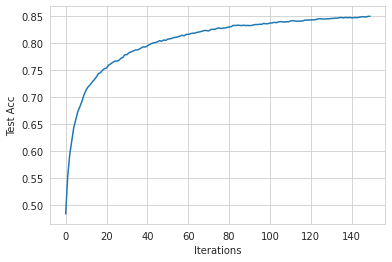

In [ ]:
plt.plot(iterations,test_acc)
plt.xlabel('Iterations')
plt.ylabel('Test Acc')

Text(0, 0.5, 'Train Acc')

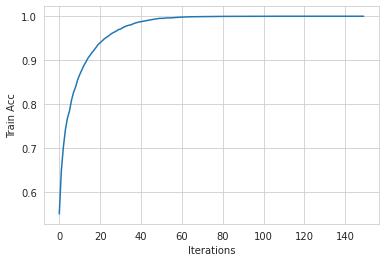

In [ ]:
plt.plot(iterations,train_acc)
plt.xlabel('Iterations')
plt.ylabel('Train Acc')

In [ ]:
best_params = grid_search_result['params']

In [ ]:
Cat_bestModel = cb.CatBoostClassifier(depth = best_params['depth'],
                                  learning_rate = best_params['learning_rate'],
                                  iterations = best_params['iterations'],
                                  l2_leaf_reg = best_params['l2_leaf_reg'],
                                  random_state=seed, verbose=0, eval_metric='Accuracy', loss_function='MultiClass')
Cat_bestModel.fit(X_train_rfe, y_train)

In [ ]:
y_pred_X = Cat_bestModel.predict(X_test[X_train_rfe.columns])
print(skm.classification_report(y_test, y_pred_X, digits=3))
print("CatBoost Test Accuracy -",skm.accuracy_score(y_test, y_pred_X)*100)

              precision    recall  f1-score   support

       blues      0.867     0.892     0.879       102
   classical      0.926     0.990     0.957       101
     country      0.800     0.824     0.812       102
       disco      0.918     0.882     0.900       102
      hiphop      0.946     0.863     0.903       102
        jazz      0.891     0.882     0.887       102
       metal      0.961     0.971     0.966       102
         pop      0.942     0.951     0.946       102
      reggae      0.877     0.912     0.894       102
        rock      0.835     0.794     0.814       102

    accuracy                          0.896      1019
   macro avg      0.896     0.896     0.896      1019
weighted avg      0.896     0.896     0.896      1019

CatBoost Test Accuracy - 89.59764474975465
